<a href="https://colab.research.google.com/github/BorisLouis/Simulation_Brownian_Nanoparticles/blob/main/DiffusionSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brownian Motion Simulation

Simulates fluorescent particles undergoing Brownian motion and generates synthetic
microscopy images according to user input.

## Pipeline
1. Simulate 3D Brownian motion (x, y, z, t) from physical parameters (D, viscosity)
2. Render each frame: each particles is a 3d dirac function with given intensity to which a 3D Airy-disk PSF (defocus-aware) is convolved.
3. Add Poisson shot noise + Gaussian read-out noise
4. Save as 16-bit grayscale TIFF (ImageJ-compatible)


## 1. Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.special import j1
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import tifffile
from pathlib import Path

try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, **kw): return x

import warnings; warnings.filterwarnings('ignore')
print('Imports OK')

from google.colab import drive
drive.mount('/content/drive')

import sys, os

# FOLDER Where data will be stored as results and Reference folder for the notebook
REPO_DIR = '/content/drive/My Drive/GoogleColab/PSF movie simulation'
sys.path.insert(0, REPO_DIR)
os.chdir(REPO_DIR)  # also set working directory, fixes relative file paths inside notebooks

Imports OK
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Parameters

In [43]:
# Microscope
LAMBDA        = 0.532e-6   # emission wavelength [m]
NA            = 1.2        # numerical aperture
N_MEDIUM      = 1.33       # refractive index (water)
PIXEL_SIZE_HR = 25e-9      # oversampled pixel size [m]
PIXEL_SIZE_LR = 100e-9     # camera pixel size [m]
UPSAMPLE      = 4          # binning factor
N_PIX_HR      = 512
N_PIX_LR      = N_PIX_HR // UPSAMPLE   # = 256

# Physics  (Stokes-Einstein: D = kT / 6πηr)
K_B           = 1.380649e-23  # [J/K]
TEMPERATURE   = 298.0         # [K]
VISCOSITY     = 4e-3        # [Pa·s]  (water @ 25°C)
RADIUS        = 100e-9         # hydrodynamic radius [m]  (100 nm diam.)

# Simulation
N_FRAMES      = 500
DT            = 0.033          # frame interval [s]
CONCENTRATION = 10000     # particles in FOV
Z_RANGE       = 1.25e-6          # ± Z half-range [m]

# Detector noise
PHOTON_SCALE  = 500     # peak photons / particle / frame
READ_NOISE_SD = 20        # read-out noise [photon-equiv.]
BACKGROUND = 100 #detector background, mostly for added noise
# Derived
D_COEFF  = K_B * TEMPERATURE / (6 * np.pi * VISCOSITY * RADIUS)
FOV_SIZE = N_PIX_HR * PIXEL_SIZE_HR

print(f'D = {D_COEFF*1e12:.3f} µm²/s')
print(f'FOV = {FOV_SIZE*1e6:.1f} µm  |  HR {N_PIX_HR}px@{PIXEL_SIZE_HR*1e9:.0f}nm  →  LR {N_PIX_LR}px@{PIXEL_SIZE_LR*1e9:.0f}nm')
print(f'{CONCENTRATION} particles  |  {N_FRAMES} frames  |  Δt = {DT*1e3:.0f} ms')

D = 0.546 µm²/s
FOV = 12.8 µm  |  HR 512px@25nm  →  LR 128px@100nm
10000 particles  |  500 frames  |  Δt = 33 ms


## 3. Brownian Motion Simulation

Each step: $\Delta\mathbf{r} \sim \mathcal{N}(0,\sigma)^3$, $\sigma=\sqrt{2D\Delta t}$.  
XY: periodic boundaries.  Z: reflective boundaries.

Positions shape: (500, 10000, 3)
Particles per frame - min: 10000, max: 10000, mean: 10000.0


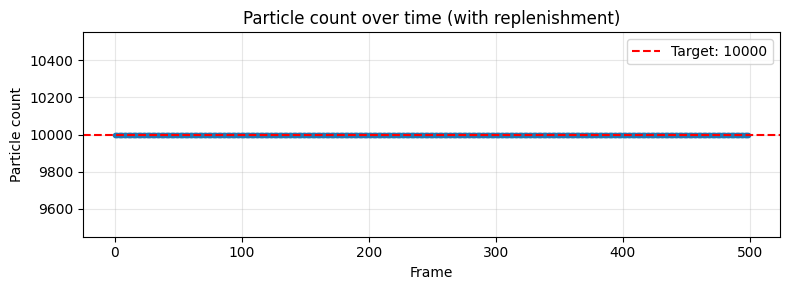

In [44]:
def simulate_brownian_3d_replenish(n_particles, n_frames, dt, D, fov_m, z_range_m, seed=42):
    """
    3D Brownian motion with particle replenishment.

    When particles diffuse beyond ±z_range_m, new particles are added near focus
    to maintain constant in-focus population.
    """
    rng = np.random.default_rng(seed)
    sigma = np.sqrt(2 * D * dt)

    # Initialize positions - store as list initially (variable size per frame)
    positions = []

    # Frame 0: uniform initialization
    pos0 = np.column_stack([
        rng.uniform(0, fov_m, n_particles),
        rng.uniform(0, fov_m, n_particles),
        rng.uniform(-z_range_m, z_range_m, n_particles)
    ])
    positions.append(pos0)

    for t in range(1, n_frames):
        # Brownian step
        pos_new = positions[t-1] + rng.normal(0, sigma, (len(positions[t-1]), 3))

        # Periodic XY
        pos_new[:, 0] %= fov_m
        pos_new[:, 1] %= fov_m

        # Check which particles left the Z range
        in_focus = np.abs(pos_new[:, 2]) <= z_range_m
        n_lost = (~in_focus).sum()

        # Keep only in-focus particles
        pos_new = pos_new[in_focus]

        # Replenish lost particles near focus
        if n_lost > 0:
            new_particles = np.column_stack([
                rng.uniform(0, fov_m, n_lost),
                rng.uniform(0, fov_m, n_lost),
                rng.uniform(-z_range_m, z_range_m, n_lost)
            ])
            pos_new = np.vstack([pos_new, new_particles])

        positions.append(pos_new)

    # Convert to fixed-size array (pad if needed for consistency)
    max_particles = max(len(p) for p in positions)
    positions_array = np.zeros((n_frames, max_particles, 3))

    for t in range(n_frames):
        n = len(positions[t])
        positions_array[t, :n, :] = positions[t]

    return positions_array, [len(p) for p in positions]


# Usage:
positions, particle_counts = simulate_brownian_3d_replenish(
    n_particles=CONCENTRATION,
    n_frames=N_FRAMES,
    dt=DT,
    D=D_COEFF,
    fov_m=FOV_SIZE,
    z_range_m=Z_RANGE
)

print(f'Positions shape: {positions.shape}')
print(f'Particles per frame - min: {min(particle_counts)}, max: {max(particle_counts)}, mean: {np.mean(particle_counts):.1f}')

# Visualize particle count over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
plt.plot(particle_counts, 'o-', markersize=3)
plt.axhline(CONCENTRATION, color='r', linestyle='--', label=f'Target: {CONCENTRATION}')
plt.xlabel('Frame')
plt.ylabel('Particle count')
plt.title('Particle count over time (with replenishment)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# @title
#def simulate_brownian_3d(n_particles, n_frames, dt, D, fov_m, z_init_range_m, seed=42):
#    rng   = np.random.default_rng(seed)
#    sigma = np.sqrt(2 * D * dt)
#    pos   = np.empty((n_frames, n_particles, 3))##
#    pos[0, :, 0] = rng.uniform(0, fov_m, n_particles)
#    pos[0, :, 1] = rng.uniform(0, fov_m, n_particles)
#    pos[0, :, 2] = rng.uniform(-z_init_range_m, z_init_range_m, n_particles)

#    for t in range(1, n_frames):
#        pos[t] = pos[t-1] + rng.normal(0, sigma, (n_particles, 3))
#        pos[t, :, 0] %= fov_m   # periodic XY
#        pos[t, :, 1] %= fov_m
#        # Z: no boundary — free diffusion
#    return pos

#N_PARTICLES_POOL = CONCENTRATION
##positions = simulate_brownian_3d(N_PARTICLES_POOL, N_FRAMES, DT, D_COEFF, FOV_SIZE, Z_RANGE)
#print(f'Pool: {N_PARTICLES_POOL} particles')



#import matplotlib.pyplot as plt

#plt.figure(figsize=(5,5))
#sc = plt.scatter(positions[0,:,0], positions[0,:,1], c=positions[0,:,2], cmap='viridis', s=10)
#plt.colorbar(sc, label='z [µm]')

### 3.1  Verify MSD = 4Dτ

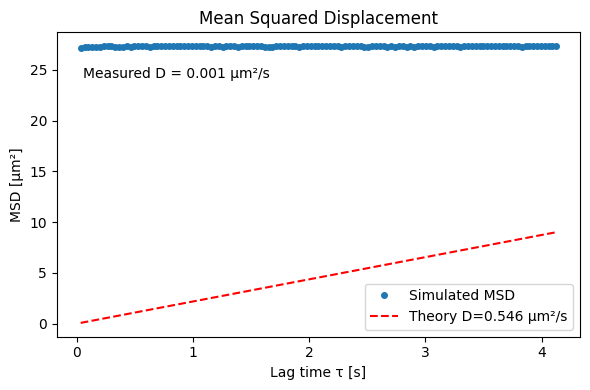

Theory  D = 0.546  |  Measured D = 0.001  µm²/s


In [46]:
def compute_msd_xy_periodic(positions, DT, fov_m, max_lag=None):
    n_frames = positions.shape[0]
    max_lag  = n_frames // 4 if max_lag is None else int(max_lag)

    lags = np.arange(1, max_lag + 1)
    msd  = np.empty_like(lags, dtype=float)

    for i, l in enumerate(lags):
        dxy = positions[l:, :, :2] - positions[:-l, :, :2]

        # minimum-image displacement in periodic box [0, fov_m)
        dxy = (dxy + 0.5 * fov_m) % fov_m - 0.5 * fov_m

        msd[i] = np.mean(np.sum(dxy**2, axis=2))

    return lags * DT, msd

tau, msd   = compute_msd_xy_periodic(positions, DT, FOV_SIZE)
D_measured = np.polyfit(tau, msd, 1)[0] / 4

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tau, msd*1e12, 'o', ms=4, label='Simulated MSD')
ax.plot(tau, 4*D_COEFF*tau*1e12, 'r--', label=f'Theory D={D_COEFF*1e12:.3f} µm²/s')
ax.set(xlabel='Lag time τ [s]', ylabel='MSD [µm²]',
       title='Mean Squared Displacement')
ax.text(0.05, 0.85, f'Measured D = {D_measured*1e12:.3f} µm²/s',
        transform=ax.transAxes)
ax.legend(); plt.tight_layout(); plt.show()
print(f'Theory  D = {D_COEFF*1e12:.3f}  |  Measured D = {D_measured*1e12:.3f}  µm²/s')

## 4. 3D PSF — Defocus-Aware Airy Disk

In-focus Airy pattern:  $I(r) = [2J_1(k\,\mathrm{NA}\,r)\,/\,(k\,\mathrm{NA}\,r)]^2$

Defocus broadening: convolve with Gaussian of width  $\sigma_z = |z|\,\mathrm{NA}^2\,/\,(n\lambda)$  [pixels]

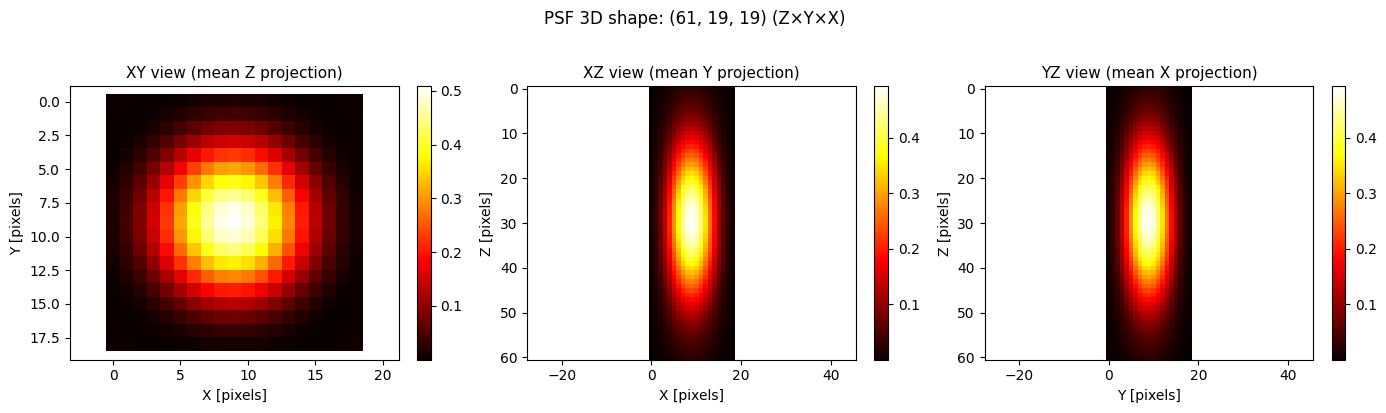

In [47]:
import numpy as np

# Optional: if you have SciPy (Colab usually does)
from numpy.fft import rfftn, irfftn
# ----------------------------
# 1) Build a 3D PSF (simple 3D "Airy x axial Gaussian" model)
#    - Lateral: Airy disk intensity
#    - Axial: Gaussian envelope (you can replace with a better axial PSF later)
# ----------------------------
def make_psf3d_airy_gaussian(
    voxel_xy_m, voxel_z_m,
    na, n_medium, lambda_m,
    psf_xy_FWHM_px=(LAMBDA/2/NA)/PIXEL_SIZE_HR, psf_z_FWHM_px=(LAMBDA/2/NA**2)/PIXEL_SIZE_HR,
    axial_sigma_m=None,
    normalize='peak',
    dtype=np.float32
):
    """
    Returns psf3d with shape (Kz, Ky, Kx), odd sizes.
    Normalized so psf3d.sum() == 1 (=> photon conservation).
    """
    # kernel sizes (odd)
    kx = 2*psf_xy_FWHM_px + 1
    ky = 2*psf_xy_FWHM_px + 1
    kz = 2*psf_z_FWHM_px  + 1

    # coordinates in meters
    yy, xx = np.mgrid[-psf_xy_FWHM_px:psf_xy_FWHM_px+1,
                      -psf_xy_FWHM_px:psf_xy_FWHM_px+1].astype(np.float32)

    rr_m = np.hypot(xx, yy) * voxel_xy_m   # radius in meters


    zz = np.arange(-psf_z_FWHM_px, psf_z_FWHM_px+1, dtype=np.float32)

    # Airy intensity (lateral)
    # x = (2*pi*n/lambda)*NA*r
    x = (2 * np.pi / lambda_m) * na * rr_m
    # j1 needs scipy.special.j1; if you already import j1 earlier, keep using that.
    # If not, use your existing j1 import.
    from scipy.special import j1
    with np.errstate(invalid='ignore', divide='ignore'):
        airy2d = np.where(x < 1e-8, 1.0, (2*j1(x)/x)**2).astype(dtype)

    # Axial Gaussian envelope
    if axial_sigma_m is None:
        # very rough DOF scale (you can tune this)
        # sigma_z ~ n*lambda / NA^2
        axial_sigma_m = psf_z_FWHM_px/2.355;

    gz = np.exp(-(zz**2) / (2*(axial_sigma_m**2))).astype(dtype)  # (kz,)

    # separable 3D PSF
    psf3d = (gz[:, None, None] * airy2d[None, :, :]).astype(dtype)

    # Normalize based on mode
    if normalize == 'peak':
        # Scale so max value = 1
        peak = float(psf3d.max())
        if peak > 0:
            psf3d /= np.float32(peak)
    elif normalize == 'sum':
        # Scale so sum = 1 (original behavior)
        s = float(psf3d.sum(dtype=np.float64))
        if s > 0:
            psf3d /= np.float32(s)

    return psf3d
# Suggested voxel sizes (your example)
VOXEL_XY = PIXEL_SIZE_HR# 25 nm
VOXEL_Z  = PIXEL_SIZE_HR

NX, NY, NZ = N_PIX_HR, N_PIX_HR, 101

# Precompute PSF kernel once
psf3d = make_psf3d_airy_gaussian(
    voxel_xy_m=VOXEL_XY, voxel_z_m=VOXEL_Z,
    na=NA, n_medium=N_MEDIUM, lambda_m=LAMBDA,
    psf_xy_FWHM_px=(LAMBDA/2/NA)/PIXEL_SIZE_HR,
    psf_z_FWHM_px=(2*LAMBDA/NA**2)/PIXEL_SIZE_HR,
    axial_sigma_m=None  # or set explicitly
)

# Visualize PSF3D with mean projections along each axis
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# XY projection (mean along Z)
xy_proj = psf3d.mean(axis=0)
im0 = axes[0].imshow(xy_proj, cmap='hot', interpolation='nearest')
axes[0].set_title('XY view (mean Z projection)', fontsize=11)
axes[0].set_xlabel('X [pixels]')
axes[0].set_ylabel('Y [pixels]')
axes[0].axis('equal')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# XZ projection (mean along Y)
xz_proj = psf3d.mean(axis=1)
im1 = axes[1].imshow(xz_proj, cmap='hot', interpolation='nearest', aspect='auto')
axes[1].set_title('XZ view (mean Y projection)', fontsize=11)
axes[1].set_xlabel('X [pixels]')
axes[1].set_ylabel('Z [pixels]')
axes[1].axis('equal')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# YZ projection (mean along X)
yz_proj = psf3d.mean(axis=2)
im2 = axes[2].imshow(yz_proj, cmap='hot', interpolation='nearest', aspect='auto')
axes[2].set_title('YZ view (mean X projection)', fontsize=11)
axes[2].set_xlabel('Y [pixels]')
axes[2].set_ylabel('Z [pixels]')
axes[2].axis('equal')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

fig.suptitle(f'PSF 3D shape: {psf3d.shape} (Z×Y×X)', fontsize=12, y=1.02)
plt.tight_layout()

plt.show()


# Computer PSF

In [48]:
import cupy as cp
from cupyx.scipy.fft import rfftn, irfftn

# Check GPU availability
print(f'GPU available: {cp.cuda.is_available()}')
if cp.cuda.is_available():
    print(f'GPU: {cp.cuda.Device()}')

# Move PSF to GPU once
psf3d_gpu = cp.asarray(psf3d, dtype=cp.float32)

# Precompute FFT of PSF (reuse for all frames)
psf_pad_gpu = cp.zeros((NZ, NY, NX), dtype=cp.float32)
kz, ky, kx = psf3d.shape
psf_pad_gpu[:kz, :ky, :kx] = psf3d_gpu
psf_pad_gpu = cp.roll(psf_pad_gpu, -kz//2, axis=0)
psf_pad_gpu = cp.roll(psf_pad_gpu, -ky//2, axis=1)
psf_pad_gpu = cp.roll(psf_pad_gpu, -kx//2, axis=2)
F_psf_gpu = rfftn(psf_pad_gpu)  # Compute once, reuse

print("PSF transferred to GPU and FFT precomputed")

GPU available: True
GPU: <CUDA Device 0>
PSF transferred to GPU and FFT precomputed


# Rendering via 3D FFT of the PSF


Rendered 10/500 (GPU)
Rendered 20/500 (GPU)
Rendered 30/500 (GPU)
Rendered 40/500 (GPU)
Rendered 50/500 (GPU)
Rendered 60/500 (GPU)
Rendered 70/500 (GPU)
Rendered 80/500 (GPU)
Rendered 90/500 (GPU)
Rendered 100/500 (GPU)
Rendered 110/500 (GPU)
Rendered 120/500 (GPU)
Rendered 130/500 (GPU)
Rendered 140/500 (GPU)
Rendered 150/500 (GPU)
Rendered 160/500 (GPU)
Rendered 170/500 (GPU)
Rendered 180/500 (GPU)
Rendered 190/500 (GPU)
Rendered 200/500 (GPU)
Rendered 210/500 (GPU)
Rendered 220/500 (GPU)
Rendered 230/500 (GPU)
Rendered 240/500 (GPU)
Rendered 250/500 (GPU)
Rendered 260/500 (GPU)
Rendered 270/500 (GPU)
Rendered 280/500 (GPU)
Rendered 290/500 (GPU)
Rendered 300/500 (GPU)
Rendered 310/500 (GPU)
Rendered 320/500 (GPU)
Rendered 330/500 (GPU)
Rendered 340/500 (GPU)
Rendered 350/500 (GPU)
Rendered 360/500 (GPU)
Rendered 370/500 (GPU)
Rendered 380/500 (GPU)
Rendered 390/500 (GPU)
Rendered 400/500 (GPU)
Rendered 410/500 (GPU)
Rendered 420/500 (GPU)
Rendered 430/500 (GPU)
Rendered 440/500 (GP

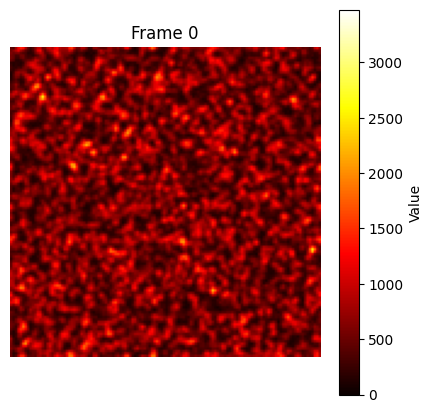

In [49]:
# Store movie in RAM (much faster than disk, fits in Colab)
NX_CAMERA = NX // UPSAMPLE  # 256
NY_CAMERA = NY // UPSAMPLE # 256

movie = np.empty((N_FRAMES, NY_CAMERA, NX_CAMERA), dtype=np.float32)


def downsample_4x4_gpu(img_gpu):
    """GPU version of 4×4 binning"""
    h, w = img_gpu.shape
    factor = 4
    return img_gpu.reshape(h//factor, factor, w//factor, factor).mean(axis=(1, 3))

for t in range(N_FRAMES):
    # Build volume on GPU
    vol_gpu = cp.zeros((NZ, NY, NX), dtype=cp.float32)

    positions_t = positions[t, :, :]

    # Filter valid particles
    z_valid_mask = (positions_t[:, 2] >= -Z_RANGE) & (positions_t[:, 2] <= Z_RANGE)
    positions_valid = positions_t[z_valid_mask]

    if len(positions_valid) == 0:
        movie[t] = BACKGROUND
        continue

    # Convert to voxel indices
    x = (positions_valid[:, 0] / VOXEL_XY).astype(cp.int32)
    y = (positions_valid[:, 1] / VOXEL_XY).astype(cp.int32)
    z = ((positions_valid[:, 2] + Z_RANGE) / VOXEL_Z).astype(cp.int32)

    # Clip to bounds
    m = (x >= 0) & (x < NX) & (y >= 0) & (y < NY) & (z >= 0) & (z < NZ)
    xi, yi, zi = x[m], y[m], z[m]

    # Place impulses on GPU
    xi_cpu = cp.asnumpy(xi)
    yi_cpu = cp.asnumpy(yi)
    zi_cpu = cp.asnumpy(zi)

    vol_cpu = cp.asnumpy(vol_gpu)
    np.add.at(vol_cpu, (zi_cpu, yi_cpu, xi_cpu), PHOTON_SCALE)
    vol_gpu = cp.asarray(vol_cpu)

    # FFT convolution on GPU (reuse precomputed F_psf_gpu)
    F_vol_gpu = rfftn(vol_gpu)
    blurred_gpu = irfftn(F_vol_gpu * F_psf_gpu, s=(NZ, NY, NX))

    # Take focal plane and add background
    img2d_gpu = blurred_gpu[NZ // 2, :, :] + BACKGROUND



    img2d_downsampled_gpu = downsample_4x4_gpu(img2d_gpu)
    movie[t] = cp.asnumpy(img2d_downsampled_gpu)  # Now 256×256

    if (t + 1) % 10 == 0:
        print(f"Rendered {t+1}/{N_FRAMES} (GPU)")



print(f"Movie shape: {movie.shape}")
print(f"Movie range: {movie.min():.1f} – {movie.max():.1f}")

# Add Poisson shot noise + Gaussian read-out noise
rng = np.random.default_rng(seed=0)
movie = rng.poisson(movie).astype(np.float32)
movie += rng.normal(0, READ_NOISE_SD, movie.shape).astype(np.float32)
movie = np.clip(movie, 0, None)

# Quick preview
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(movie[0], cmap="hot",vmin=0, vmax=movie.max())

plt.colorbar( label='Value')
plt.title("Frame 0")
plt.axis("off")
plt.show()

## 8. Save 16-bit Grayscale TIFF Stack (ImageJ-compatible)

In [50]:
import tifffile
# Build descriptive filename with simulation parameters
filename = (
    f'mov_diff_N{CONCENTRATION}_'
    f'r{int(RADIUS)*1e9}nm_'
    f'eta{VISCOSITY*1e3:.1f}mPas_'
    f'frames{N_FRAMES}_'
    f'dt{int(DT*1000)}ms.tiff'
)

output_path = f'{REPO_DIR}/Results/{filename}'

# Convert to uint16
movie_clean = np.nan_to_num(movie, nan=0.0)
movie_clean = np.clip(movie_clean, 0, None)

mn, mx = movie_clean.min(), movie_clean.max()
movie_u16 = movie_clean.astype(np.uint16)

# Save as ImageJ-compatible TIFF stack
tifffile.imwrite(
    output_path,
    movie_u16,
    imagej=True,
    resolution=(1/(PIXEL_SIZE_LR*1e6), 1/(PIXEL_SIZE_LR*1e6)),
    metadata={
        'unit': 'um',
        'axes': 'TYX',
        'finterval': DT,
        'D_um2_per_s': float(D_COEFF*1e12),
        'NA': NA,
        'lambda_nm': LAMBDA*1e9,
        'pixel_nm': PIXEL_SIZE_LR*1e9,
        'n_particles': CONCENTRATION,
        'n_frames': N_FRAMES,
        'viscosity_mPas': VISCOSITY*1e3,
        'temperature_K': TEMPERATURE,
    }
)

print(f'Saved: {filename}')
print(f'  Full path: {output_path}')
print(f'  Shape: {movie_u16.shape}')
print(f'  Size: {movie_u16.nbytes / 1e6:.1f} MB')

Saved: mov_diff_N10000_r0.0nm_eta4.0mPas_frames500_dt33ms.tiff
  Full path: /content/drive/My Drive/GoogleColab/PSF movie simulation/Results/mov_diff_N10000_r0.0nm_eta4.0mPas_frames500_dt33ms.tiff
  Shape: (500, 128, 128)
  Size: 16.4 MB


## 10. Inline Movie Preview

In [51]:
from IPython.display import HTML
fig_a, ax_a = plt.subplots(figsize=(5,5))
vmax_a = np.percentile(movie, 99)
im_a   = ax_a.imshow(movie[0], cmap='hot', vmin=0, vmax=vmax_a, interpolation='nearest')
ax_a.axis('off')
ttl = ax_a.set_title('Frame 0')

def _upd(t):
    im_a.set_data(movie[t])
    ttl.set_text(f'Frame {t}  t={t*DT:.2f} s')
    return [im_a, ttl]

ani = animation.FuncAnimation(
    fig_a, _upd, frames=range(0,N_FRAMES,max(1,N_FRAMES//50)),
    interval=80, blit=True)
plt.close(fig_a)
HTML(ani.to_jshtml())

## Summary

| Parameter | Value |
|:--|:--|
| Particle radius | 50 nm |
| Diffusion coeff. (theory) | D_COEFF µm²/s |
| Diffusion coeff. (DDM)    | D_median µm²/s |
| Particles in FOV | CONCENTRATION |
| Final image size | 256×256 px @ 100 nm/px |
| Movie | N_FRAMES frames @ DT s/frame |
| Output | `ddm_simulation.tiff` (16-bit, ImageJ TYX) |

At high concentration, single-particle tracking fails (overlapping PSFs).  
DDM recovers the correct diffusion coefficient from ensemble statistics.